<a href="https://colab.research.google.com/github/PilarToZiomal/Fashion-MNIST-AI/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Convert dataset into a tensor 4D (# of img, H, W, Colour chnl)
transform = transforms.ToTensor()

In [5]:
# Train, test Data
train_data = datasets.FashionMNIST('data',train=True,download=True,transform=transform)
test_data = datasets.FashionMNIST('data',train=False,download=True,transform=transform)

# Show Data
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
# Step by Step:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle = False )

In [7]:
# Define CNN Model
conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
conv2 = nn.Conv2d(16, 32, 3, 1, 1) # Explained above

In [8]:
# Grab 1 img
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [9]:
X_Train.shape

torch.Size([1, 28, 28])

In [10]:
x = X_Train.view(1,1,28,28)

In [11]:
# 1st convolution
x = F.relu(conv1(x))
x.shape

torch.Size([1, 16, 28, 28])

In [12]:
# 1st pooling
x = F.max_pool2d(x, 2, 2) # kernal=2, stride=2
x.shape # 28 / 2 = 14

torch.Size([1, 16, 14, 14])

In [13]:
# 2nd convolution
x = F.relu(conv2(x))
x.shape

torch.Size([1, 32, 14, 14])

In [14]:
# 2nd pooling
x = F.max_pool2d(x, 2, 2)
x.shape # 14 / 2 = 7

torch.Size([1, 32, 7, 7])

In [15]:
# Model Class
class FashionCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)

    self.fc1 = nn.Linear(7*7*32, 512) # 7*7*32 -> Look 2nd pooling
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-View -> flatten data out
    X = X.view(-1, 7*7*32) # -1 because we can vary the batch size

    # FCL (Fully Connected Layers)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)


In [16]:
# Instance of Model
torch.manual_seed(7)
model = FashionCNN()
model

FashionCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [18]:
# LFO (Loss Function Optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
import time # Just my preference (can be skipped)
start_time = time.time() # can be skipped

# Variables
epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1
    y_pred = model(X_train) # predicted values from the training set
    loss = criterion(y_pred, y_train) # Compare predictions to answers

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print some results
    if b % 1000 == 0:
      print(f'Epoch: {i} | Batch: {b} | Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time() # can be skipped
total = current_time - start_time # can be skipped
print(f'Training took: {total/60} minutes.') # can be skipped

Epoch: 0 | Batch: 1000 | Loss: 0.13275423645973206
Epoch: 0 | Batch: 2000 | Loss: 0.6177486181259155
Epoch: 0 | Batch: 3000 | Loss: 0.5397838354110718
Epoch: 0 | Batch: 4000 | Loss: 0.04102397710084915
Epoch: 0 | Batch: 5000 | Loss: 0.3566568195819855
Epoch: 0 | Batch: 6000 | Loss: 0.3091900944709778
Epoch: 1 | Batch: 1000 | Loss: 0.08670975267887115
Epoch: 1 | Batch: 2000 | Loss: 0.462501585483551
Epoch: 1 | Batch: 3000 | Loss: 0.17781026661396027
Epoch: 1 | Batch: 4000 | Loss: 0.019920986145734787
Epoch: 1 | Batch: 5000 | Loss: 0.1971825510263443
Epoch: 1 | Batch: 6000 | Loss: 0.27654120326042175
Epoch: 2 | Batch: 1000 | Loss: 0.6578271389007568
Epoch: 2 | Batch: 2000 | Loss: 0.15380775928497314
Epoch: 2 | Batch: 3000 | Loss: 0.3673977255821228
Epoch: 2 | Batch: 4000 | Loss: 0.08983008563518524
Epoch: 2 | Batch: 5000 | Loss: 0.13123789429664612
Epoch: 2 | Batch: 6000 | Loss: 0.39005178213119507
Epoch: 3 | Batch: 1000 | Loss: 0.46933451294898987
Epoch: 3 | Batch: 2000 | Loss: 0.096981

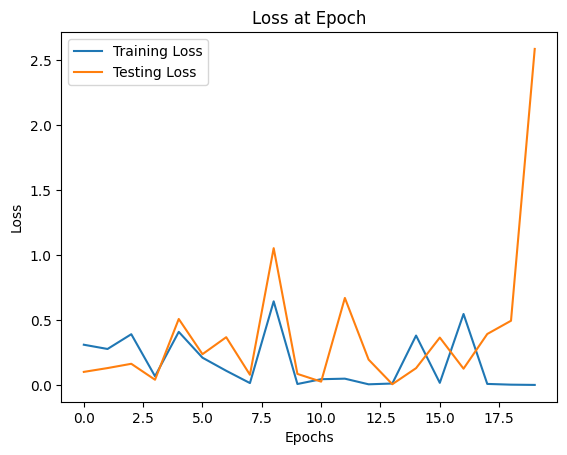

In [24]:
# Plot some data
# Change data type
train_losses = [tl.item() for tl in train_losses]

# Loss graph
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

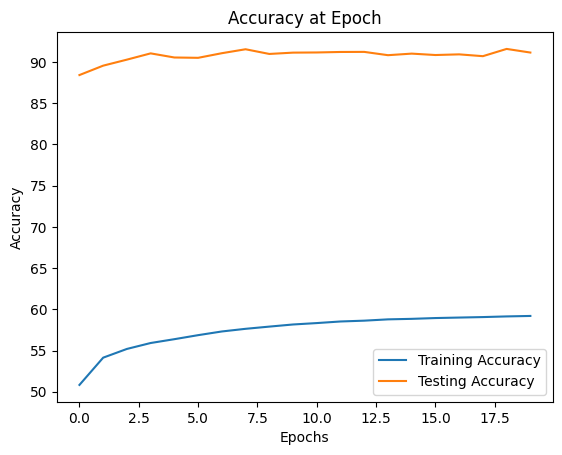

In [26]:
# Accuracy graph
plt.plot([t/1000 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at Epoch')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [27]:
test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

In [29]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct.item()/100}%')

Test Accuracy: 91.15%


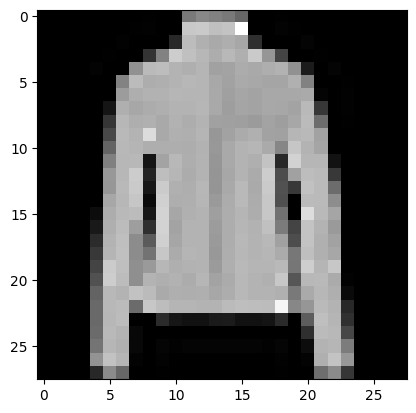

In [30]:
# Random image
ri = 1234
plt.imshow(test_data[ri][0].view(28,28), cmap='gray')

In [31]:
# Just the data
test_data[ri][0].view(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
         0.0000, 0.0000, 0.4745, 0.5294, 0.5020, 0.4745, 0.4000, 0.0000, 0.0000,
         0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0078,
         0.0000, 0.0000, 0.7804, 0.7882, 0.7451, 0.7647, 0.9961, 0.0000, 0.0000,
         0.0118, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000,
         0.0000, 0.1608, 0.7333, 0.6863, 0.6588, 0.6784, 0.6510, 0.1843, 0.0000,
         0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.2000,
         0.5059, 0.8000, 0.7490, 0.7137, 0.6745, 0.7176, 0.6824, 0.7882, 0.5843,
         0.2667, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000

In [39]:
# Pass through model
model.eval()
with torch.no_grad():
  n_pred = model(test_data[ri][0].view(1,1,28,28))
n_pred.argmax()

tensor(4)

In [40]:
# 0	T-shirt/top
# 1	Trouser
# 2	Pullover
# 3	Dress
# 4	Coat
# 5	Sandal
# 6	Shirt
# 7	Sneaker
# 8	Bag
# 9	Ankle boot